### Install necessary libraries

In [43]:
# !pip install langdetect
# !pip install emoji
# !pip install transformers

### Import libraries

In [44]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from langdetect import detect
import re
import matplotlib.pyplot as plt
import seaborn as sns

import emoji
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification


import warnings
warnings.filterwarnings("ignore")

### Download nltk packages

In [45]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

### Input files

In [46]:
comments_path = 'Comments.csv'
labelled_path = 'final_labelled_data.csv'

In [47]:
# Loading the data into pandas dataframes
df_comments = pd.read_csv(comments_path)
df_labelled = pd.read_csv(labelled_path)

## Data preprocessing

### Drop these comlumns

In [48]:
df_labelled = df_labelled.dropna(subset=['Topic', 'Comment'])

### Function to check english comments

In [49]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Remove non-English comments
df_labelled = df_labelled[df_labelled['Comment'].apply(is_english)]

### Data parameters

In [50]:
# This is the total number of samples you want.
n_samples = 20000

# The number of unique topics.
n_categories = df_labelled['Topic'].nunique()

# Calculate the number of samples per each category.
samples_per_category = n_samples // n_categories

In [51]:
# Now you can create a new dataframe with an equal number of samples from each category.
df_labelled = df_labelled.groupby('Topic').apply(lambda x: x.sample(min(len(x), samples_per_category))).reset_index(drop=True)

### Preprocessing Labelled data

In [52]:
def remove_emoji(text):
    return emoji.demojize(text, delimiters=("", ""))

def preprocess_text(text):
    text = remove_emoji(text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [token for token in text if token.isalnum()]
    return ' '.join(text)

In [53]:
df_labelled['Comment']=df_labelled['Comment'].apply(preprocess_text)

### Convert score to sentiment classes

In [54]:
def score_to_label(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df_labelled['Sentiment_Label'] = df_labelled['Sentiment'].apply(score_to_label)

## Data visualize

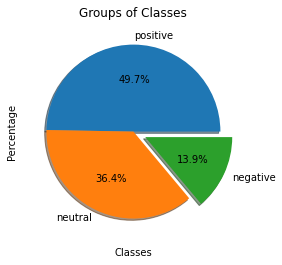

In [56]:
plt.figure(figsize=(8, 4))
df_labelled.groupby('Sentiment_Label')['Sentiment_Label'].count().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', explode=(0, 0, 0.15), shadow=True)
plt.title("Groups of Classes")
plt.ylabel('Percentage')
plt.xlabel('Classes')
plt.show()

**Based on the data, the majority of the classes fall under the "positive" category, accounting for 49.7% of the data. The "neutral" class follows with 36.4%, while the "negative" class represents the smallest portion at 13.9%. This distribution suggests a relatively optimistic sentiment overall, with a significant portion of the data expressing positive opinions or views.**

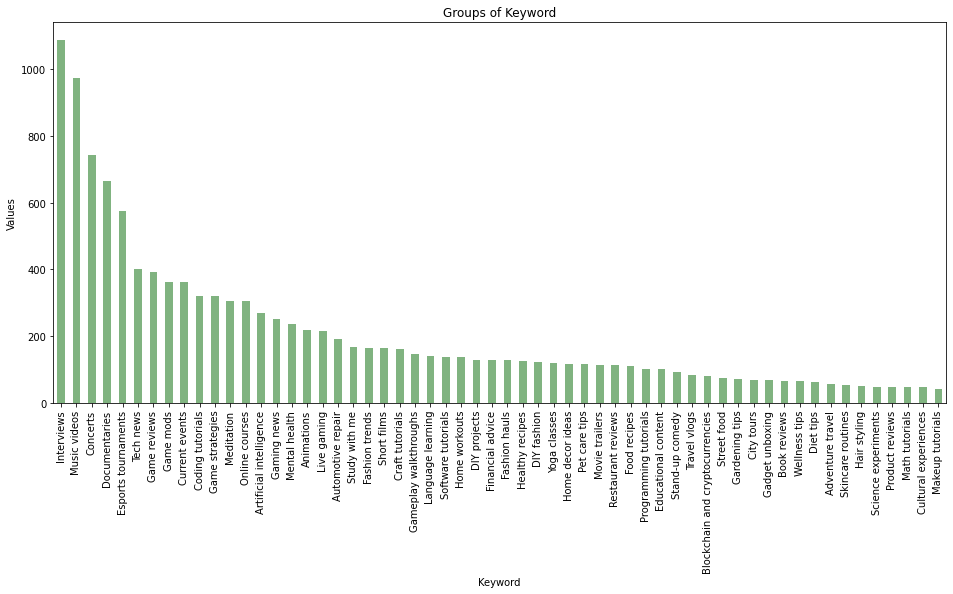

In [57]:
plt.figure(figsize=(16, 7))
df_labelled.groupby('Keyword')['Keyword'].count().sort_values(ascending=False).plot(kind='bar', color=(0.5, 0.7, 0.5))
plt.title("Groups of Keyword")
plt.ylabel('Values')
plt.xlabel('Keyword')
plt.show()

**We can observed that the top three keywords with the highest counts are "Interviews," "Music videos," and "Concerts." This suggests a strong interest in media-related content, with a focus on interviews and music-related experiences. Other popular keywords include documentaries, esports tournaments, and tech news, indicating a diverse range of preferences and interests among viewers. Additionally, keywords such as coding tutorials, game strategies, and online courses highlight the popularity of educational and skill-building content in various fields**

In [58]:
df_labelled['Topic'] = df_labelled['Topic'].apply(lambda x: " ".join(x.split('/')[-1].split('_')))

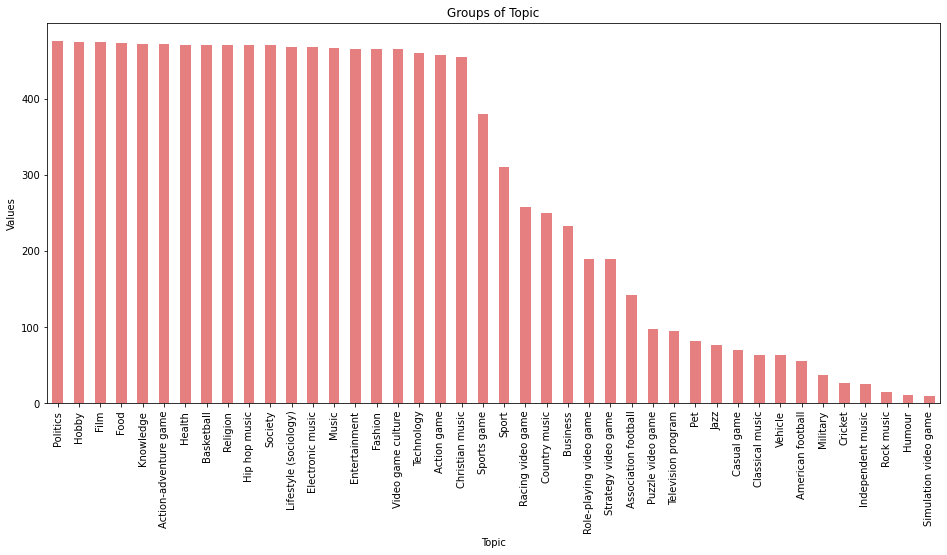

In [59]:
plt.figure(figsize=(16, 7))
df_labelled.groupby('Topic')['Topic'].count().sort_values(ascending=False).plot(kind='bar', color=(0.9, 0.5, 0.5))
plt.title("Groups of Topic")
plt.ylabel('Values')
plt.xlabel('Topic')
plt.show()

**We can observed that the topics with the highest counts are politics, hobby, and film. These three topics seem to generate the most interest and discussions among individuals. Other popular topics include food, knowledge, and action-adventure games, reflecting the diverse range of interests people have.**

In [60]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df_labelled['Sentiment_Label'] = df_labelled['Sentiment_Label'].map(label_map)

### Split dataset to train and test

In [61]:
train_df, test_df = train_test_split(df_labelled, test_size=0.2, random_state=42)

## Bert model

In [62]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['Comment'].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['Comment'].tolist(), truncation=True, padding=True, max_length=128)

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['Sentiment_Label'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['Sentiment_Label'].tolist()
))

### Pretrained model

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

In [98]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Training

In [81]:
epochs = 5
batch_size = 32

In [82]:
history = model.fit(train_dataset.shuffle(1000).batch(batch_size), epochs=epochs, batch_size=batch_size)

Epoch 1/2
302/302 [==============================] - 164s 495ms/step - loss: 0.4921 - sparse_categorical_accuracy: 0.8292
Epoch 2/2
302/302 [==============================] - 151s 501ms/step - loss: 0.3130 - sparse_categorical_accuracy: 0.8954


### Training graphs

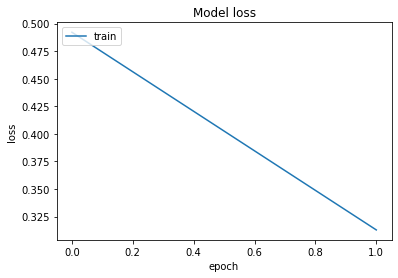

In [84]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

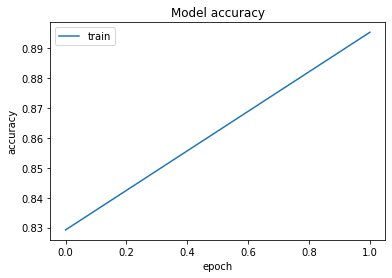

In [85]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Save model

In [86]:
model_path = "comment"
model.save_pretrained(model_path)

### Evaluate on testset

In [102]:
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size), verbose=0)
print(f"Test Loss: {test_loss}\nAccuracy: {test_accuracy}")

Test Loss: 0.3499335050582886
Accuracy: 0.8817427158355713


## Vader

In [88]:
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis on comments
df_labelled['vader_scores'] = df_labelled['Comment'].apply(lambda x: sia.polarity_scores(x))

# Extract the compound score
df_labelled['vader_compound'] = df_labelled['vader_scores'].apply(lambda x: x['compound'])

# Convert the compound score to sentiment label
df_labelled['vader_pred'] = df_labelled['vader_compound'].apply(lambda x : 2 if x >= 0.05 else (1 if x <= -0.05 else 0))

### Evaluate vader

In [89]:
# Calculate the accuracy
accuracy = (df_labelled['vader_pred'] == df_labelled['Sentiment_Label']).mean()

print(f"Accuracy of VADER sentiment analysis: {accuracy}")

Accuracy of VADER sentiment analysis: 0.5026143248402357


## Applying the sentimental model to the unseen data

### Process comments data

In [90]:
df_comments = df_comments[df_comments['Comment'].apply(is_english)]
df_comments['Comment'] = df_comments['Comment'].apply(preprocess_text)

### Load the model and tokenizer

In [96]:
model_path = "comment"
model = TFBertForSequenceClassification.from_pretrained(model_path, num_labels=3)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at comment were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at comment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [92]:
# Define batch size
batch_size = 100

# Create an empty list to store predictions
predictions = []

# Loop over the comments in batches
for i in range(0, len(df_comments['Comment']), batch_size):
    # Tokenize the current batch of comments
    input_ids = tokenizer(df_comments['Comment'].iloc[i:i+batch_size].tolist(), padding=True, truncation=True, max_length=256, return_tensors='tf')

    # Make sentiment predictions for the current batch
    logits = model(input_ids)['logits']
    preds = tf.argmax(logits, axis=-1).numpy()

    # Append the predictions to the list
    predictions.extend(preds)

# Add the predictions as a new column in the dataframe
df_comments['Sentiment_Prediction'] = predictions

### Convert prediction to class labels

In [93]:
label_map = {2: 'positive', 1: 'neutral', 0: 'negative'}
df_comments['Sentiment_Label'] = df_comments['Sentiment_Prediction'].map(label_map)

In [94]:
df_comments

,Comment,Sentiment_Prediction,Sentiment_Label
0,bro iphone 11 new 128gb sahi rahega aya iphone...,2,positive
1,keep this series up i luv these kind of walkth...,2,positive
2,enders game that wa an awesome space movie tha...,2,positive
3,there a crusader king 2 mod called elder king ...,2,positive
4,the problem with be careful what you sign is t...,2,positive
...,...,...,...
7205,for me richarlyson song wa the best,2,positive
7206,bro i need a 10 thousand diamond,1,neutral
7207,big griff always killin it love ya man,2,positive
7208,shadow ka lag issue solve hoo jaye ba fir miln...,2,positive
